In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation

Data import for scikit learn models and transform to TensorFlow dataset for neural network model.

In [2]:
def df_to_dataset(dataframe, shuffle=False, batch_size=256):
  """
  Create TensorFlow dataset from Pandas data frame.
  Label column name should be 'target'
  """
  df = dataframe
  #df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [3]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv')
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


In [4]:
data_tf = df_to_dataset(data.copy(),  shuffle=False, batch_size=256)
data_tf

<PrefetchDataset element_spec=({'nace': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'esize_class': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gender': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'age_class': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'lpk': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'education': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'experience': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

# Import models and predict

In [5]:
import joblib
xgb_model = joblib.load('./Models/XGBoost_model.joblib')
xgb_mc_model = joblib.load('./Models/XGBoost_manual_cat_model.joblib')
grb_model = joblib.load('./Models/GRBoost_model.joblib')
lm_model = joblib.load('./Models/LM_model.joblib')
rf_model = joblib.load('./Models/RF_model.joblib')
svr_model = joblib.load('./Models/SVR_model.joblib')
sk_voting_model = joblib.load('./Models/SklearnVoting_model.joblib')
tf_model = tf.keras.models.load_model("./Models/tf_model")

In [6]:
data_ml = data.copy()

data_ml['xgb'] = xgb_model.predict(data)
data_ml['xgb_mc'] = xgb_mc_model.predict(data)
data_ml['grb'] = grb_model.predict(data)
data_ml['rf'] = rf_model.predict(data)
data_ml['lm'] = lm_model.predict(data)
data_ml['svr'] = svr_model.predict(data)
data_ml['voting'] = sk_voting_model.predict(data)

data_ml['tf'] = tf_model.predict(data_tf)

data_ml.head()

128/128 [==============================] - 0s 1ms/step


,nace,esize_class,gender,age_class,lpk,education,experience,target,xgb,xgb_mc,grb,rf,lm,svr,voting,tf
0,C,1_49,M,40-49,p721,G2,13,8.20,4.503678,4.408886,4.176350,4.778167,4.061958,4.009178,4.390707,4.049001
1,C,1_49,F,40-49,p334,G2,0,2.51,3.051344,3.037208,2.980969,3.041897,2.992907,3.122998,3.266770,3.292751
2,M,50_249,F,40-49,p522,G2,18,2.19,3.425669,3.228116,3.172908,3.256087,3.945913,2.907824,3.278419,3.245212
3,M,50_249,F,40-49,p522,G2,12,2.19,3.298834,3.212965,3.066702,3.219982,3.849712,2.802480,3.200731,3.176937
4,M,50_249,F,14-29,p522,G2,0,2.19,2.991804,3.021976,2.920913,2.993366,3.531646,2.741929,3.123216,2.880577


In [7]:
target_columns = ['target', 'xgb', 'xgb_mc', 'grb', 'rf', 'lm', 'svr', 'voting', 'tf']

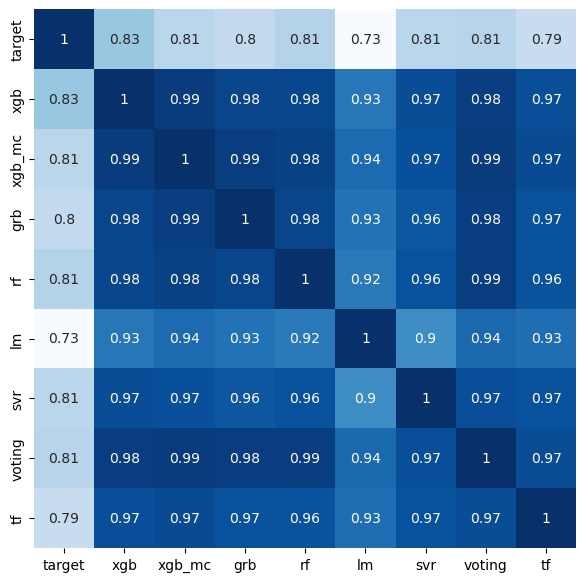

In [8]:
plt.figure(figsize = (7, 7))
sns.heatmap(data_ml[target_columns].corr(), annot=True, cmap='Blues', cbar=False);

Highest correlation with target has Extreme Gradient Boosting model (xgb) with one hot encoding. Use of ordinal feature encoding does not improve the model. The worst correlation is with  Linear Regression model prediction. 

In [9]:
data_ml.to_csv('../Data/LT_DU_ML_results.csv', index=False)